# Predicting commute times

The point of this basic exercise is to train a neural network to predict the continuous `commute_time` variable, as a function of various things like source and destination coordinates, time of day, and commute type ( a categorical variable ).

This is to be shown during a very introductory workshop. The end goal is to absolutely do better than a linear regression, which someone is teaching beforehand.

Problem : I can train a mean convnet, but basic fully-connected nets, with no regularisation, for regression, I have no idea how to build effectively. Your insight is super appreciated ( and as soon as possible, this is next weekend... )

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout

%matplotlib inline

Using TensorFlow backend.


### Raw data

The raw data is pretty trivial. I know that commute time is a function of the L1 distance between source and destination ( although that is hidden knowledge that the workshop audience will not have ). The data is pretty hard, we'll be making it somewhat easier, but that doesn't change the fact a neural net *should* do better.

In [2]:
data = pd.read_csv("../data/commute_times.csv")

data.head()

,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day,commute_type,commute_time
0,0.824392,0.475742,0.933873,-0.292262,8.856115,TRAIN,1.028704
1,0.795889,0.075121,0.240722,0.465027,9.058129,BIKE,4.634294
2,-0.902398,0.124019,0.666059,-0.260070,8.524607,CAR,6.491592
3,0.496755,-0.747187,0.161702,0.385728,9.676583,BUS,5.415297
4,-0.085848,-0.914451,-0.058177,0.278478,14.784042,BUS,1.499639


### Generate some basic features

In [3]:
# Create some categorical variables from commute_type
data = pd.concat([data, pd.get_dummies(data["commute_type"])], axis=1).drop(["commute_type"], axis=1)

# Add L2 norm
data.loc[:, "distance"] = np.sqrt(
    (data["destination_latitude"] - data["source_latitude"])**2 +
    (data["destination_longitude"] - data["source_longitude"])**2
)

data.head()

,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day,commute_time,BIKE,BUS,CAR,TRAIN,WALK,distance
0,0.824392,0.475742,0.933873,-0.292262,8.856115,1.028704,0,0,0,1,0,0.775768
1,0.795889,0.075121,0.240722,0.465027,9.058129,4.634294,1,0,0,0,0,0.678408
2,-0.902398,0.124019,0.666059,-0.260070,8.524607,6.491592,0,0,1,0,0,1.614800
3,0.496755,-0.747187,0.161702,0.385728,9.676583,5.415297,0,1,0,0,0,1.181421
4,-0.085848,-0.914451,-0.058177,0.278478,14.784042,1.499639,0,1,0,0,0,1.193250


### Create train and test datasets and scale the features for neural net use

In [4]:
np.random.seed(0)

# Create X and y
X = data.drop(["commute_time"], axis=1)
y = data["commute_time"]

# Scale features
X = StandardScaler().fit_transform(X)

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Linear regression

In [5]:
# Train a linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Calculate its RMSE
lr_rmse = np.sqrt(np.mean((lr.predict(X_test) - y_test) **2 ))
print("RMSE linear regression : {:.2f}".format(lr_rmse))
print("( R^2 : {:.3f} )".format(lr.score(X_test, y_test)))

RMSE linear regression : 5.59
( R^2 : 0.333 )


### Neural net

RMSE neural network : 5.04


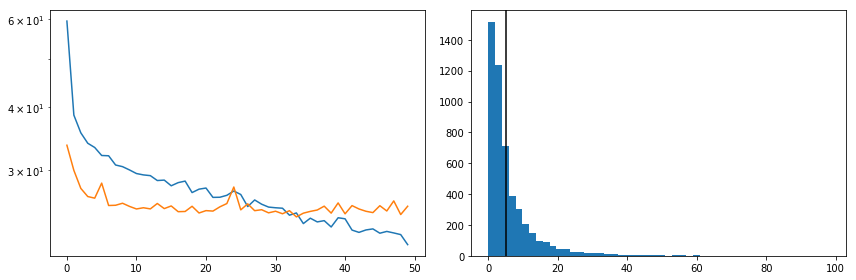

In [6]:
model = Sequential()

model.add(Dense(512, activation="relu", input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="relu"))

model.compile(loss="mse", optimizer="adam")

history = model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=50,
    verbose=0,
    validation_data=(X_test, y_test)
)

# Calculate RMSE
nn_rmse = np.sqrt(model.evaluate(X_test, y_test, verbose=0))
print("RMSE neural network : {:.2f}".format(nn_rmse))


plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.semilogy(history.history["loss"])
plt.semilogy(history.history["val_loss"])

plt.subplot(122)
plt.hist(data["commute_time"], bins=50)
plt.axvline(nn_rmse, c="k")

plt.tight_layout()